## Iterative Cleaning of the Training and Test Data

In [80]:
#imports
import pandas as pd
import numpy as np
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [81]:
#load the datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Initial Focus
Based on my general knowledge of house prices, as well as a [few](https://www.thespruce.com/things-to-look-for-house-hunting-1977279) [articles](https://homeia.com/buy-house/how-long-does-it-take-to-buy-a-house/) I [read](https://money.com/how-to-price-a-home/), my initial focus will be on quantitative variables of the home (square footage, age, number of beds, number of bathrooms) and some categorical variables (neighborhood, quality of the house). In addition, because my family is focused on the overall feeling of privacy for their home, qualities of the lot will be included, including fencing.

## DataFrame Checker
Some initial functions help me format the dataframes properly and validate expected outputs. At first I put all of my data cleaning and engineering into this function, but I've put the rest at the bottom so I can show the full process that led to my ultimate decision making.

In [82]:
def df_checker(df):
    '''
    Returns the DataFrame passed with more pythonically named columns.
    Prints warnings for null or unexpected values.
    Columns Checked: overall_qual, overall_cond, gr_liv_area, year_built, year_remod/add
    Columns Cleaned: garage_area, total_bsmt_sf, bsmt_full_bath, full_bath, bsmt_half_bath, half_bath
    '''
    #rename columns pythonically
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    
    ##numeric columns
    #check columns that can't be 0 or null for null values
    for col in ['overall_qual', 'gr_liv_area', 'year_built', 'year_remod/add', 'lot_config', 'paved_drive', 'neighborhood', 'lot_frontage', 'exter_qual', 'bsmt_qual', 'kitchen_qual']:
        if df[col].isna().sum():
            print(f"{col.title()} has {df[col].isna().sum()} null values")
        
    #check for values outside the appropriate range
    if set(df['overall_qual'].unique()) - set(range(1,11)):
        print(f"Overall_qual has outlier {set(df['overall_qual'].unique()) - set(range(1,11))}")
    
    if set(df['overall_cond'].unique()) - set(range(1,11)):
        print(f"Overall_cond has outlier {set(df['overall_qual'].unique()) - set(range(1,11))}")
    
    ##categorical columns
    #check categoricals for outliers
    if set(df['lot_config'].unique()) - {'Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'}:
        print(f"Lot_config has outlier {set(df['lot_config'].unique()) - {'Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'}}")
    
    if set(df['paved_drive'].unique()) - {'Y', 'P', 'N'}:
        print(f"Paved_drive has outlier {set(df['paved_drive'].unique()) - {'Y', 'P', 'N'}}")

        
    ##ordinal columns
    #exter_qual
    for col in ['exter_qual', 'kitchen_qual', 'bsmt_qual']:
        if set(df[col].unique()) - {'Ex', 'Gd', 'TA', 'Fa', 'Po'}:
            print(f"{col.title()} has outlier {set(df[col].unique()) - {'Ex', 'Gd', 'TA', 'Fa', 'Po'}}")
    
    #zoning
    if set(df['ms_zoning'].unique()) - {'A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RP', 'RM'}:
        print(f"MS Zoning has outlier {set(df['ms_zoning'].unique()) - {'A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'}}")
    
    #neighborhood
    ngbr_difference = set(df['neighborhood'].unique()) - {'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'}
    if ngbr_difference:
        print(f"Neighborhood has outlier {ngbr_difference}")
    return df

In [83]:
train = df_checker(train)
test = df_checker(test)

Lot_Frontage has 330 null values
Bsmt_Qual has 55 null values
Bsmt_Qual has outlier {nan}
Lot_Frontage has 160 null values
Bsmt_Qual has 25 null values
Bsmt_Qual has outlier {nan}


## Explore the Data
Because there are so many variables here, I want to first focus on those with the highest correlation with sale price, at the same time taking into account potential multicollinearity between those variables. I will start with the top numeric variables and categorical variables to create a solid baseline model, and then take into account problem-specific variables to tune my model for my clients.

### Missingness

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

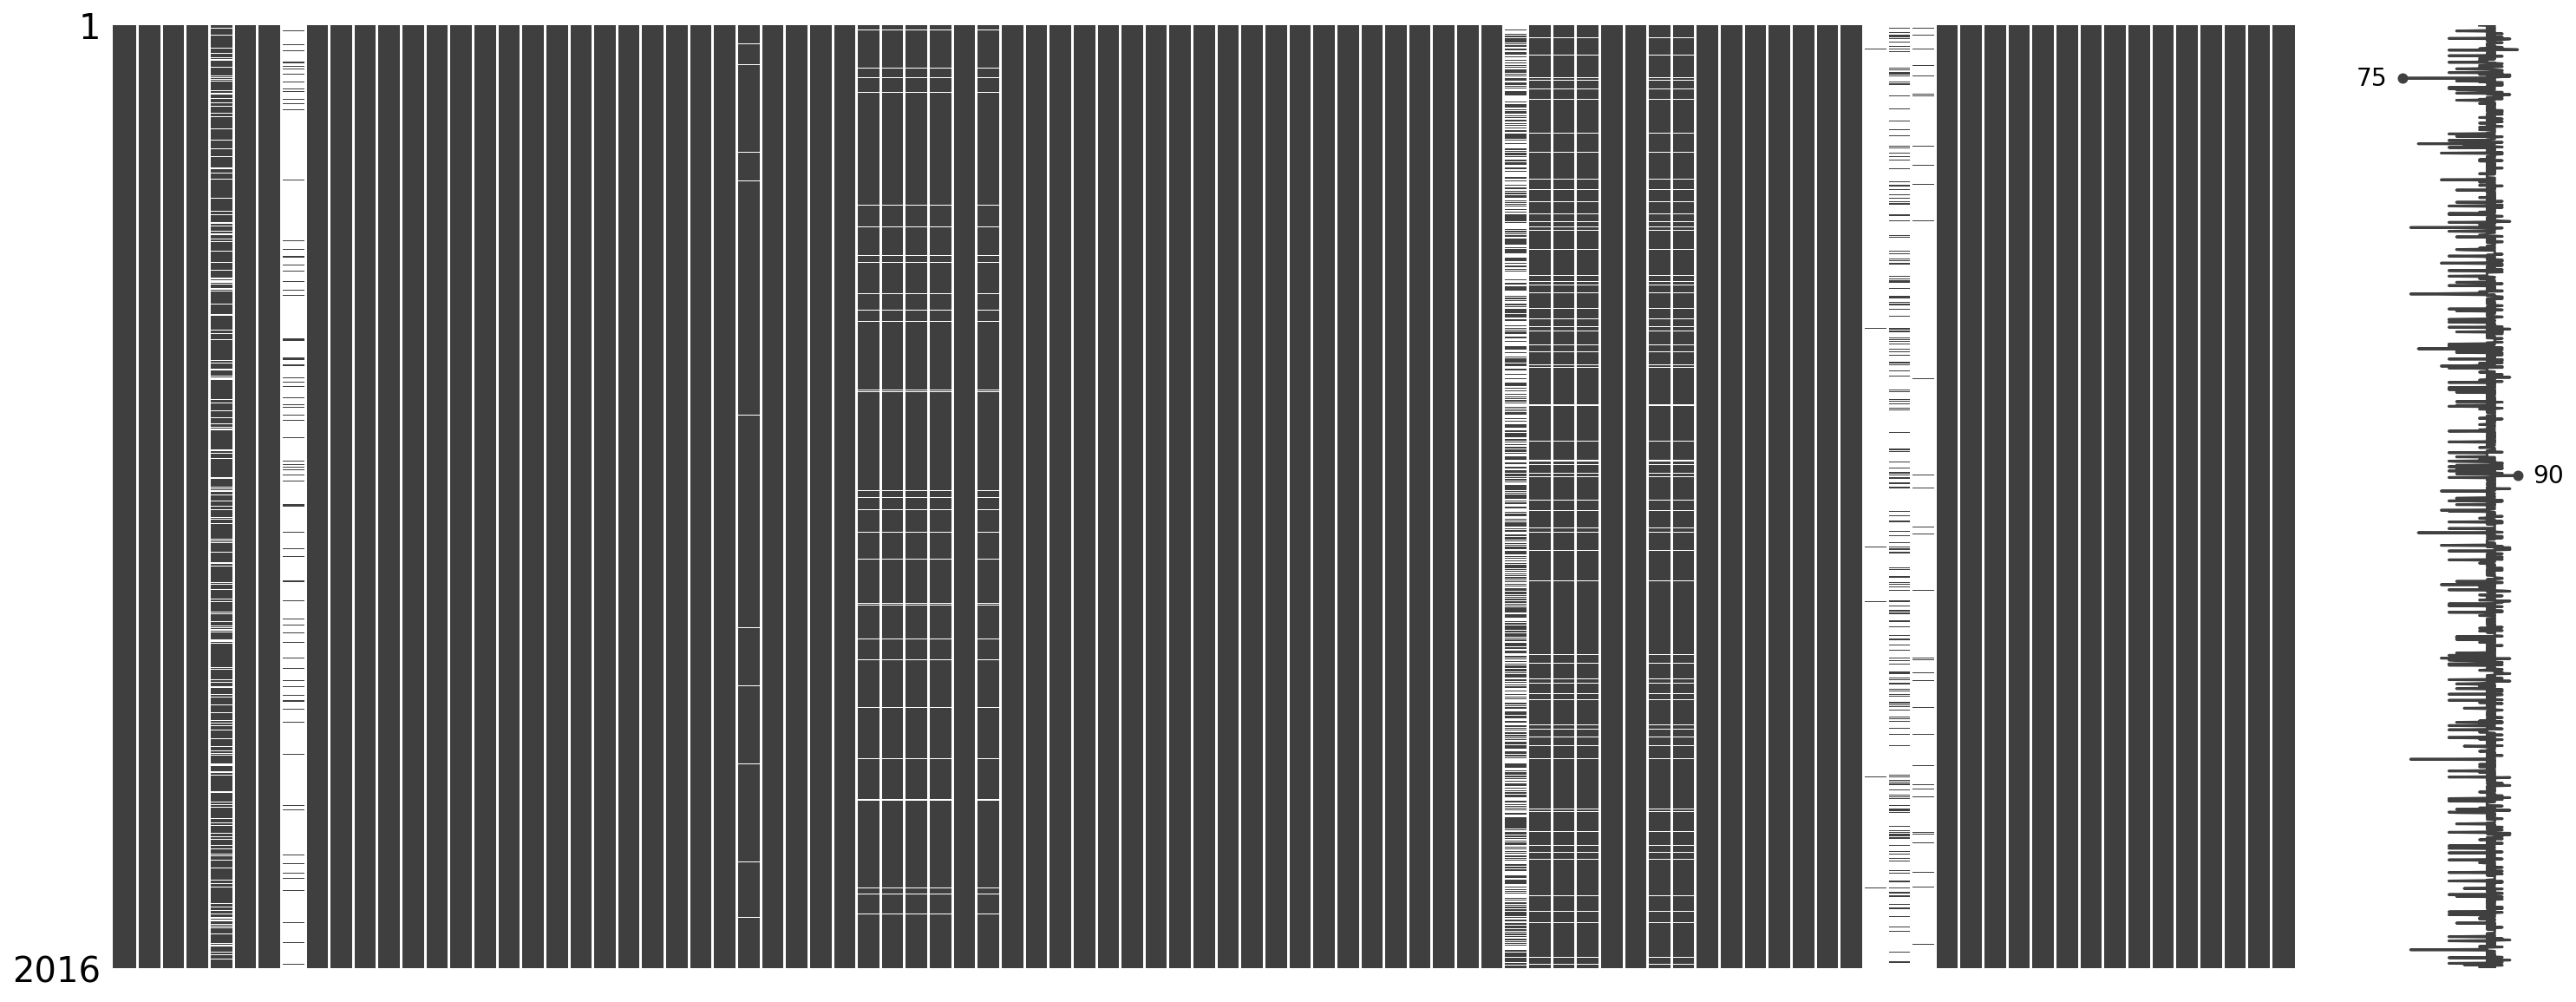

In [134]:
msn.matrix(train)
plt.show()

Here we can see that there are a few sets of columns that are likely to be missing in groups. By cross-referencing with the info above, I can see that those are the garage and basement columns. All of these columns should be null, or 0, when there is no garage or basement. This can be indicated by checking the Garage Qual and Basement Exposure columns.

In [86]:
train[train['garage_qual'].isna()][[x for x in train.columns if 'garage' in x]].isna().sum()

garage_type      113
garage_yr_blt    114
garage_finish    114
garage_cars        1
garage_area        1
garage_qual      114
garage_cond      114
dtype: int64

In [87]:
train[train['garage_qual'].isna() & ~(train['garage_type'].isna())][[x for x in train.columns if 'garage' in x]]


,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


From here we can impute the continuous columns that have NaN (which should be 0) and impute NaN for the garage that claims to have a type but has no other information.

In [88]:
for col in ['garage_area', 'garage_cars']:
        train[col] = train[col].replace(np.nan, 0)

train.loc[train[train['garage_qual'].isna() & ~(train['garage_type'].isna())].index, 'garage_type'] = np.nan

A similar method can be taken for the null basement features. Continuous variables where there is no basement should be 0 instead of NaN, and rows which claim not to have a basement by Basement Exposure but have other quality data should be inspected more thoroughly.

In [89]:
train[train['bsmt_exposure'].isna()][[x for x in train.columns if 'bsmt' in x]].isna().sum()


bsmt_qual         55
bsmt_cond         55
bsmt_exposure     58
bsmtfin_type_1    55
bsmtfin_sf_1       1
bsmtfin_type_2    55
bsmtfin_sf_2       1
bsmt_unf_sf        1
total_bsmt_sf      1
bsmt_full_bath     2
bsmt_half_bath     2
dtype: int64

In [90]:
train[train['bsmt_exposure'].isna() & ~(train['bsmt_qual'].isna())][[x for x in train.columns if 'bsmt' in x]]


,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,bsmt_full_bath,bsmt_half_bath
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


In [91]:
train['bsmt_exposure'].value_counts()

No    1339
Av     288
Gd     203
Mn     163
Name: bsmt_exposure, dtype: int64

In this case it is clear that these basements do exist, but just have no information for Basement Exposure. I am going to treat this as a clerical error, assuming that the proper input was actually "No Exposure" rather than "No Basement". "No Exposure" was also the most common value in this column, so adding 3 extra datapoints to it shouldn't mess with it too much

In [92]:
#replace continuous nan with 0
for col in ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']:
        train[col] = train[col].replace(np.nan, 0)

#replace bsmt_cond nan with "No"
for row in train[train['bsmt_exposure'].isna() & ~(train['bsmt_qual'].isna())].index:
    train.loc[row, 'bsmt_exposure'] = 'No'

Other columns we see with many nulls are lot frontage, alley, mason veneer type and area, fireplace quality, pool quality, fence, and miscellaneous features. The nulls in the categoricals can be explained by the absence of that feature for that house, but lot frontage and mason veneer area should not be null.

In [93]:
train[train['mas_vnr_type'].isna()][[x for x in train.columns if 'mas' in x]].isna().sum()

mas_vnr_type    22
mas_vnr_area    22
dtype: int64

In [94]:
#identical nullness, so we can just replace mason area values with 0
train['mas_vnr_area'] = train['mas_vnr_area'].replace(np.nan, 0)

In [95]:
train[train['lot_frontage'].isna()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,5,2010,COD,142000
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,Shed,400,6,2007,WD,112500
23,12,527165230,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,185000
27,1534,909277040,50,RL,NaN,11700,Pave,Grvl,IR1,HLS,...,0,0,NaN,NaN,NaN,0,7,2008,WD,198000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,560,532376110,20,RL,NaN,7791,Pave,NaN,IR1,Lvl,...,0,0,NaN,GdWo,NaN,0,10,2009,WD,129000
2022,2872,909475020,20,RL,NaN,16381,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,12,2006,WD,223000
2028,2526,534127190,20,RL,NaN,20781,Pave,NaN,IR2,Lvl,...,0,0,NaN,NaN,NaN,0,6,2006,WD,262500
2031,25,527402250,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,149900


In [96]:
#inside lot definition https://www.allbusiness.com/barrons_dictionary/dictionary-inside-lot-4952919-1.html
train[train['lot_frontage'].isna()]['lot_config'].value_counts()

Inside     190
Corner      67
CulDSac     61
FR2         11
FR3          1
Name: lot_config, dtype: int64

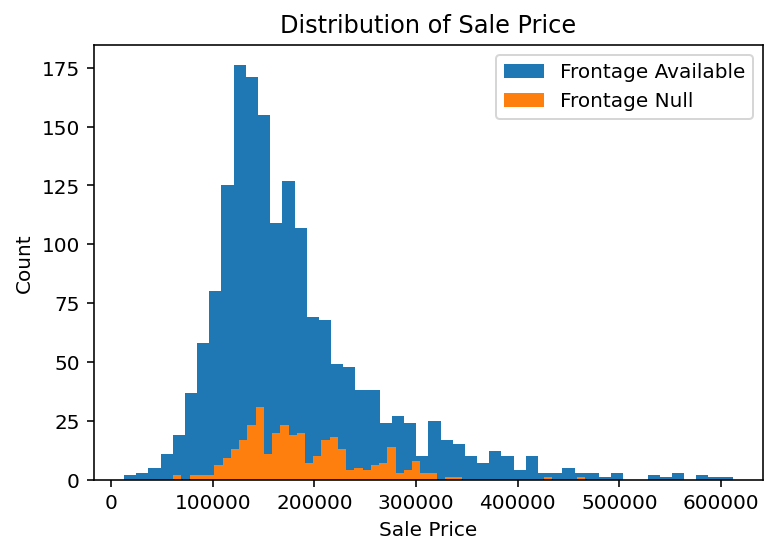

In [97]:
plt.hist(train[~train['lot_frontage'].isna()]['saleprice'], bins=50, label='Frontage Available')
plt.hist(train[train['lot_frontage'].isna()]['saleprice'], bins=50, label='Frontage Null')
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.legend()
plt.show()

The first thing I did with lot frontage was look up a few of the houses in the way provided by the readme, to confirm if perhaps there are just a large number of houses in Ames that have long easement driveways and therefore no frontage. I [checked a few](https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=2&PageID=1104) with null frontage from each lot configuration type, but they all bordered the street and should have had a frontage number.

Clearly, the frontage for these rows is just missing. This is a great candidate for a KNN imputer, but only if I believe that the continuous frontage of a lot has an appropriate amount of power when predicting sale price. In my correlation heatmap below, frontage is not even in the top 10. To confirm it's lack of power, I made the same correlation heatmap below, but this time only with rows where frontage was not null. Even then, frontage is not even in the top 15 correlated continuous rows. Rather than using frontage, lot configuration holds similar signal, and is a more reliably accounted-for variable.

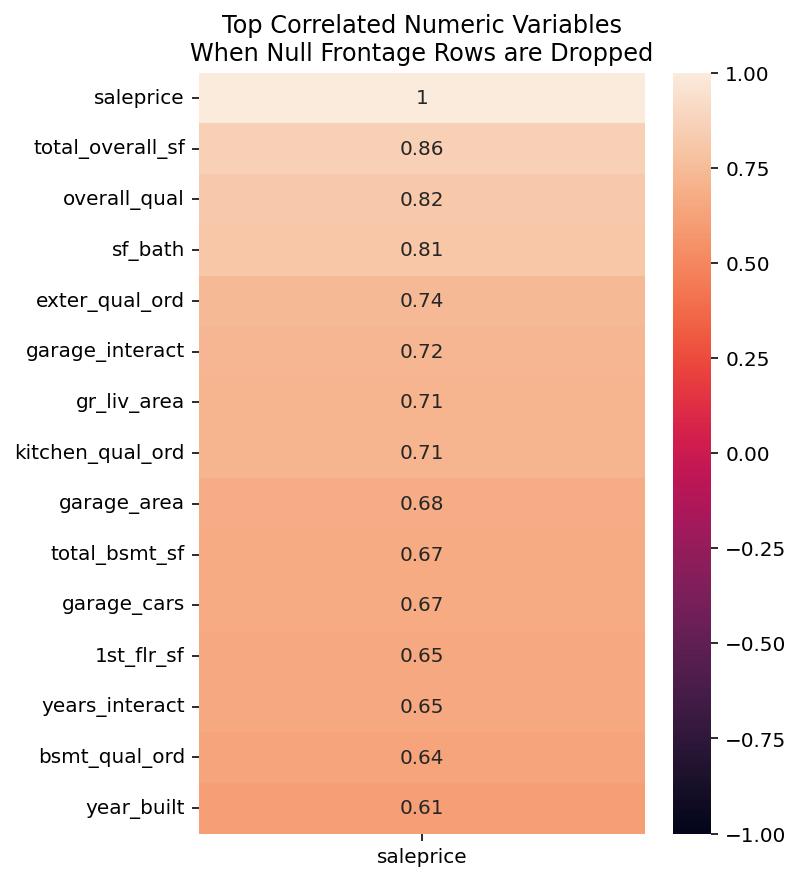

In [135]:
plt.figure(figsize=(5,7))
sns.heatmap(train[~train['lot_frontage'].isna()].corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(15), annot=True, vmin=-1, vmax=1)
plt.title('Top Correlated Numeric Variables\nWhen Null Frontage Rows are Dropped')
plt.show()

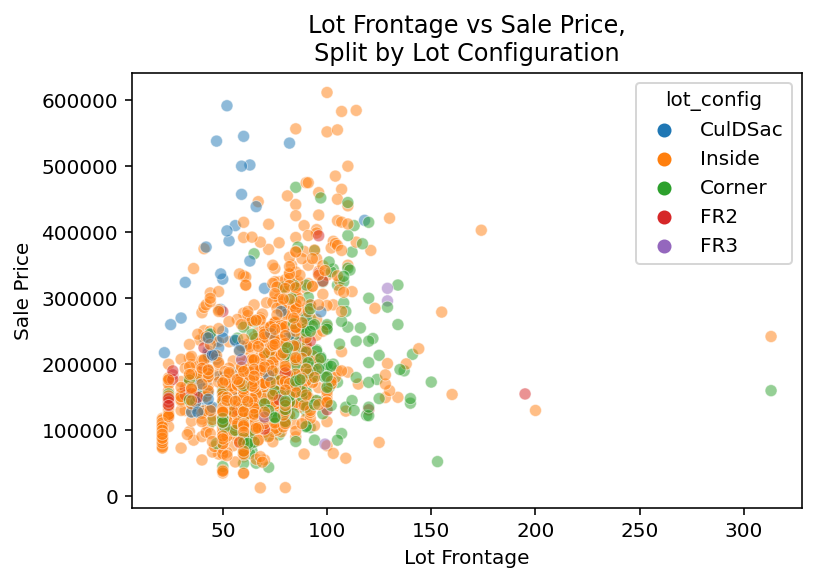

In [99]:
sns.scatterplot(x=train['lot_frontage'],
                y=train['saleprice'], 
                hue=train['lot_config'], 
                alpha=.5)
plt.title('Lot Frontage vs Sale Price,\nSplit by Lot Configuration')
plt.xlabel('Lot Frontage')
plt.ylabel('Sale Price')
plt.show()

Here we can confirm that lot configuration holds similar signal to lot frontage.

### The Y Variable

First I want to take a look at the target variable.

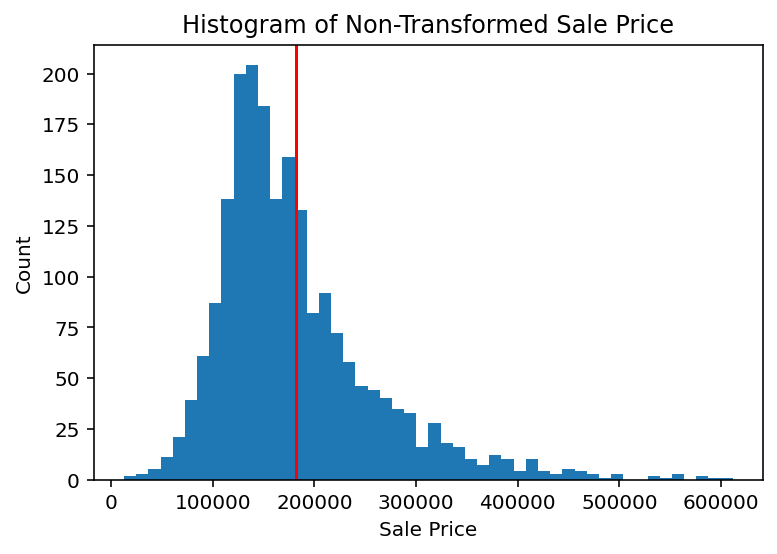

In [100]:
plt.hist(train['saleprice'], bins=50);
plt.axvline(train['saleprice'].mean(), color='red')
plt.title('Histogram of Non-Transformed Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.show()

I can see immediately that the sale price has a distinct right skew. I looked into this because I heard Kyle mention it in office hours, and I came to the same conclusion as him, that a log-transform on sale price will lead to much more accurate predictions. This will make interpretation a little more difficult, but the coefficients can be converted back into interpretable terms with a little effort.

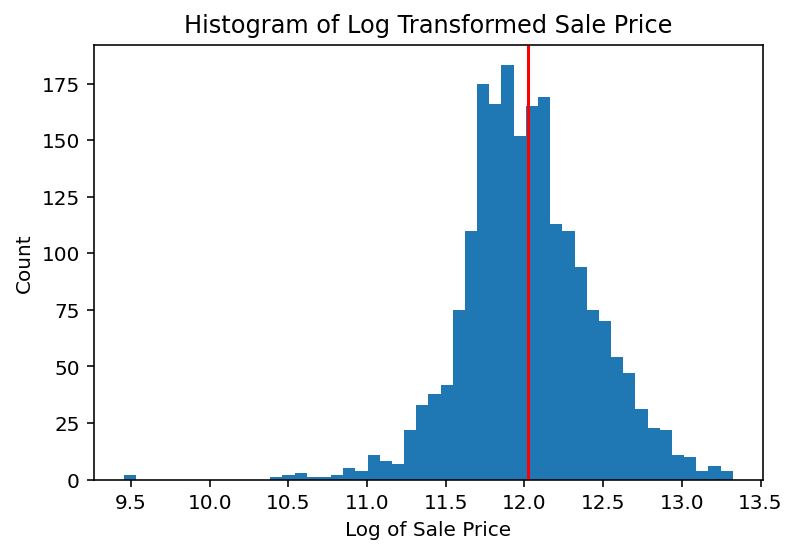

In [101]:
plt.hist(np.log(train['saleprice']), bins=50)
plt.axvline(np.log(train['saleprice']).mean(), color='red')
plt.title('Histogram of Log Transformed Sale Price')
plt.xlabel('Log of Sale Price')
plt.ylabel('Count')
plt.show()

With the transformation done, we can see that there is now a slight left skew. 

Because my hypothetical family are middle of the road buyers, I need the model to predict best for middle of the road houses. Therefore, I am going to remove any observations +/- 3 std deviations of the mean for the transformed sale price. This is more generous than using 2.5 for my outliers, because I want to lose as few rows as possible, and only takes 14 data points away.

In [102]:
train = train.drop(train[np.log(train['saleprice']) < (np.log(train['saleprice']).mean() - 3 * np.log(train['saleprice']).std())].index)
train = train.drop(train[np.log(train['saleprice']) > (np.log(train['saleprice']).mean() + 3 * np.log(train['saleprice']).std())].index)


### X Variable EDA
#### Numeric

In [103]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2034.0,1.475746e+03,8.431405e+02,1.0,7.622500e+02,1486.5,2.198500e+03,2930.0
pid,2034.0,7.134661e+08,1.886902e+08,526301100.0,5.284591e+08,535453180.0,9.071801e+08,924152030.0
ms_subclass,2034.0,5.719518e+01,4.292533e+01,20.0,2.000000e+01,50.0,7.000000e+01,190.0
lot_frontage,1704.0,6.900880e+01,2.325905e+01,21.0,5.800000e+01,68.0,8.000000e+01,313.0
lot_area,2034.0,1.003807e+04,6.697106e+03,1300.0,7.500000e+03,9417.5,1.149800e+04,159000.0
overall_qual,2034.0,6.119469e+00,1.393889e+00,1.0,5.000000e+00,6.0,7.000000e+00,10.0
overall_cond,2034.0,5.572763e+00,1.098613e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.0
year_built,2034.0,1.971809e+03,3.006312e+01,1872.0,1.954000e+03,1974.0,2.001000e+03,2010.0
year_remod/add,2034.0,1.984271e+03,2.096438e+01,1950.0,1.965000e+03,1993.0,2.004000e+03,2010.0
mas_vnr_area,2034.0,9.759735e+01,1.724387e+02,0.0,0.000000e+00,0.0,1.577500e+02,1600.0


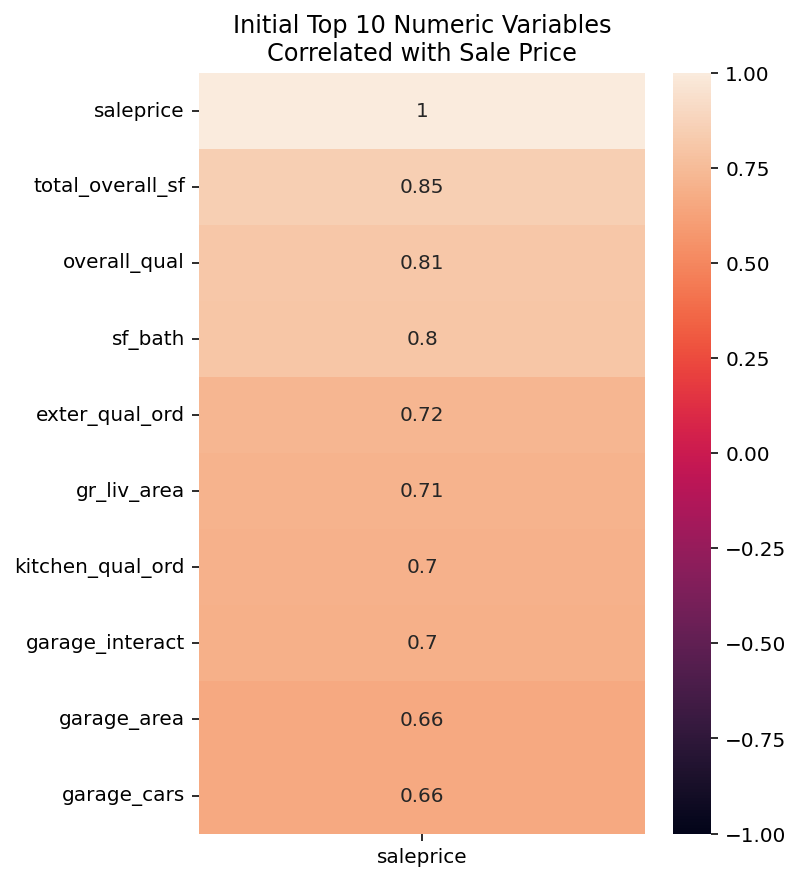

In [136]:
plt.figure(figsize=(5,7))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(10), annot=True, vmin=-1, vmax=1)
plt.title('Initial Top 10 Numeric Variables\nCorrelated with Sale Price')
plt.show()

Initially I can see that Overall Quality of the home is most highly correlated with sale price, followed by the general amount of space in the home/garage, followed by the years built and remodeled. My first concern is that there will be multi-collinearity between some of these features, so I need to control for that.

In [105]:
#vif stuff: https://corporatefinanceinstitute.com/resources/knowledge/other/variance-inflation-factor-vif/
#maybe I can keep sub-parts of interaction terms: https://statisticalhorizons.com/multicollinearity/
#adapted from vif helper code written by Devin
#I tried to write it differently but as you can see from this example as well, not many ways to do the same thing: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
def vif_df(data):
    data = data.dropna()
    df = pd.DataFrame(columns=['vif'], index=data.columns)
    df['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    
    return df.sort_values(by='vif', ascending=False)

In [106]:
vif_1 = vif_df(train._get_numeric_data())
vif_1.head(20)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif
2nd_flr_sf,inf
gr_liv_area,inf
low_qual_fin_sf,inf
bsmtfin_sf_1,inf
bsmtfin_sf_2,inf
bsmt_unf_sf,inf
total_bsmt_sf,inf
1st_flr_sf,inf
yr_sold,2.520214e+04
pid,1.917570e+01


As we can see here, there is high multicollinearity between the many squarefoot variables. The two ways to handle this are to create an overall squarefoot variable, or some interaction term. I'm going to test both and see which has higher correlation with predicting sale price. First though I will check these columns quickly for outliers to drop.

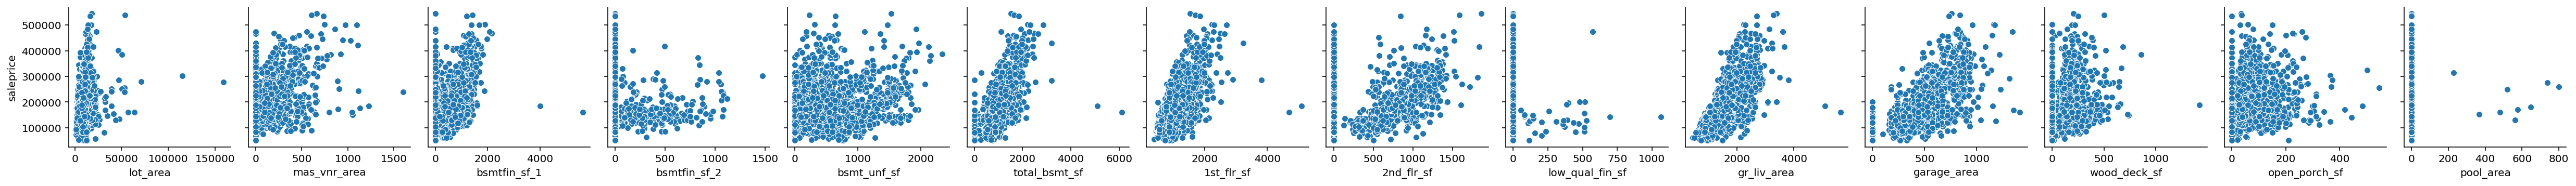

In [107]:
sns.pairplot(train, x_vars=[x for x in train.columns if 'sf' in x or 'area' in x], y_vars=['saleprice'])

In [108]:
#drop clear outliers
train = train.drop(train[train['lot_area'] > 100000].index)
train = train.drop(train[train['mas_vnr_area'] > 1500].index)
train = train.drop(train[train['total_bsmt_sf'] > 4000].index)

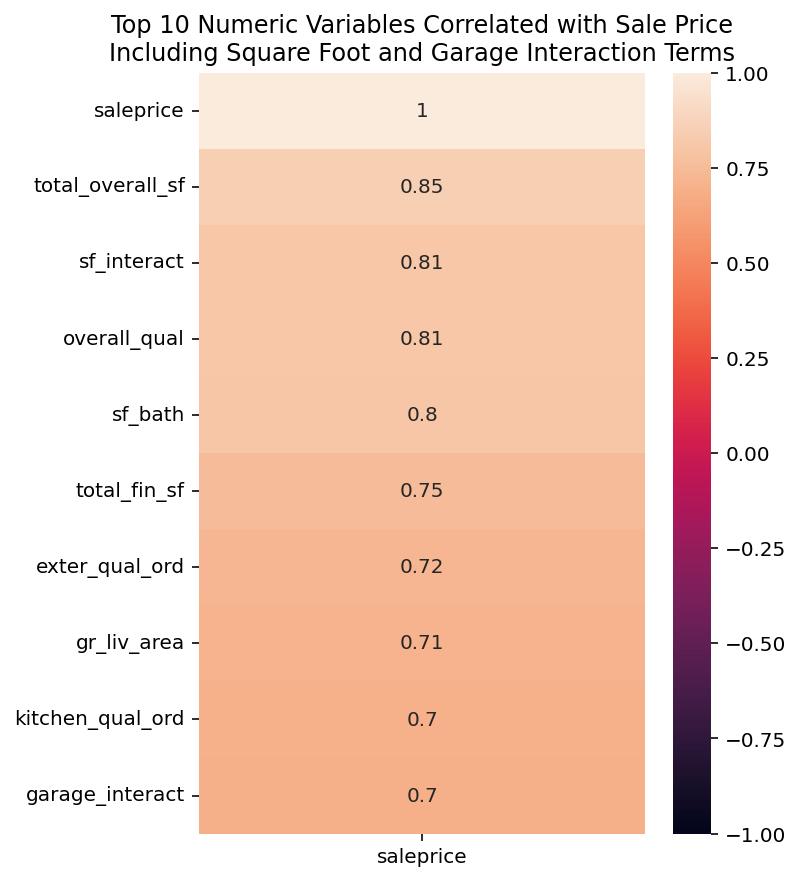

In [138]:
train['total_overall_sf'] = train['gr_liv_area'] + train['total_bsmt_sf'] + train['garage_area']
train['total_fin_sf'] = train['gr_liv_area'] + train['total_bsmt_sf'] - train['bsmt_unf_sf']
train['sf_interact'] = train['gr_liv_area'] * train['total_bsmt_sf']
train['garage_interact'] = train['garage_cars'] * train['garage_area']
plt.figure(figsize=(5,7))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(10), annot=True, vmin=-1, vmax=1)
plt.title('Top 10 Numeric Variables Correlated with Sale Price\nIncluding Square Foot and Garage Interaction Terms')
plt.show()

Here we can see that Total Overall Squarefoot, which is the combination of living area above grade, total basement squarefoot, and garage area, is now the predictor most highly correlated with sale price. We still have to test this with the model, but it looks like a good way to deal with the house squarefoot variables that are multicollinear, as well as taking on the garage variables.

There is a problem with taking care of it this way, which is that because it is an additive term, we can't use any sub-portion of that term in the model. We can, however, use multiplicative interaction terms that use those sub-variables. Of the interaction terms I made above, I am going to keep the interaction of the two garage terms and the total overall square footage of the house and garage, dropping the others.

I'm also going to check really quickly for outliers in these new columns, and ensure that they have proper linearity with sale price.

In [110]:
train = train.drop(columns=['total_fin_sf', 'sf_interact'])

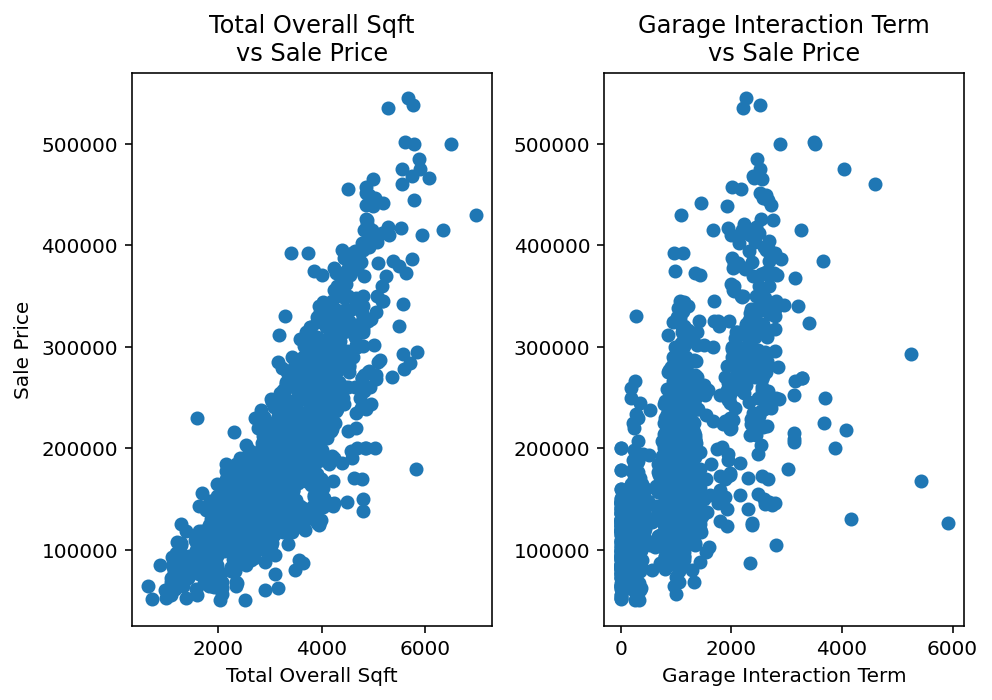

In [111]:
fig, ax = plt.subplots(1,2, figsize=(7,5))

ax[0].scatter(train['total_overall_sf'], train['saleprice'])
ax[1].scatter(train['garage_interact'], train['saleprice'])
ax[0].set_title('Total Overall Sqft\nvs Sale Price')
ax[0].set_xlabel('Total Overall Sqft')
ax[0].set_ylabel('Sale Price')
ax[1].set_title('Garage Interaction Term\nvs Sale Price')
ax[1].set_xlabel('Garage Interaction Term')
fig.tight_layout()

The interaction of the garage term is appearing less linear than expected. Still, I'm going to leave it in to give garage a little more signal, but potentially drop it during iterative modeling.

Now lets check for multicollinearity again.

In [112]:
vif_2 = vif_df(train._get_numeric_data().drop(columns=[x for x in vif_1.index if vif_1.loc[x, 'vif'] > 50000]))
vif_2


,vif
yr_sold,25895.987873
garage_interact,28.481610
pid,18.927097
garage_area,14.495559
garage_cars,10.938922
saleprice,8.905133
total_overall_sf,7.049138
year_built,5.154003
garage_yr_blt,4.425287
id,4.319207


Here year sold stands out as a problem variable. Next we'll look at all three year variables together.

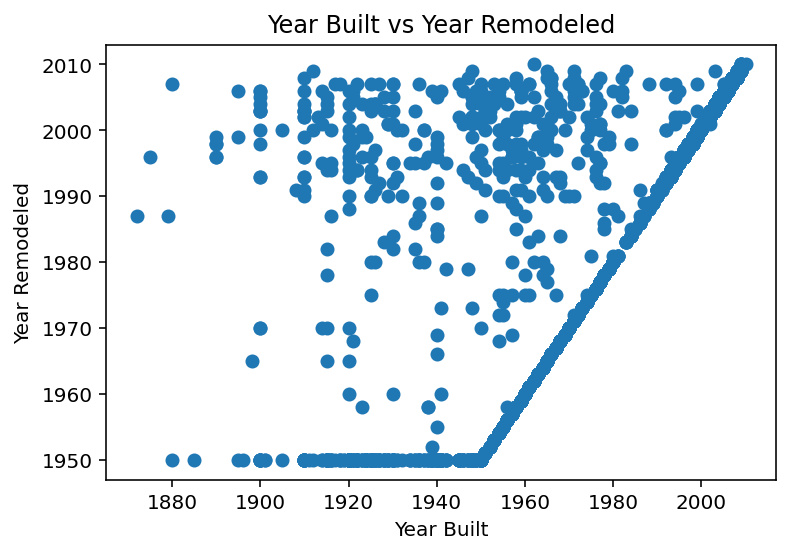

In [139]:
plt.scatter(train['year_built'], train['year_remod/add'])
plt.title('Year Built vs Year Remodeled')
plt.xlabel('Year Built')
plt.ylabel('Year Remodeled')
plt.show()

By the nature of the way the data is stored, with Year Remod/Add being the same as Year Built if no further additions have been made, there is going to be a relationship between these two variables. This makes it another prime candidate for an interaction term. 

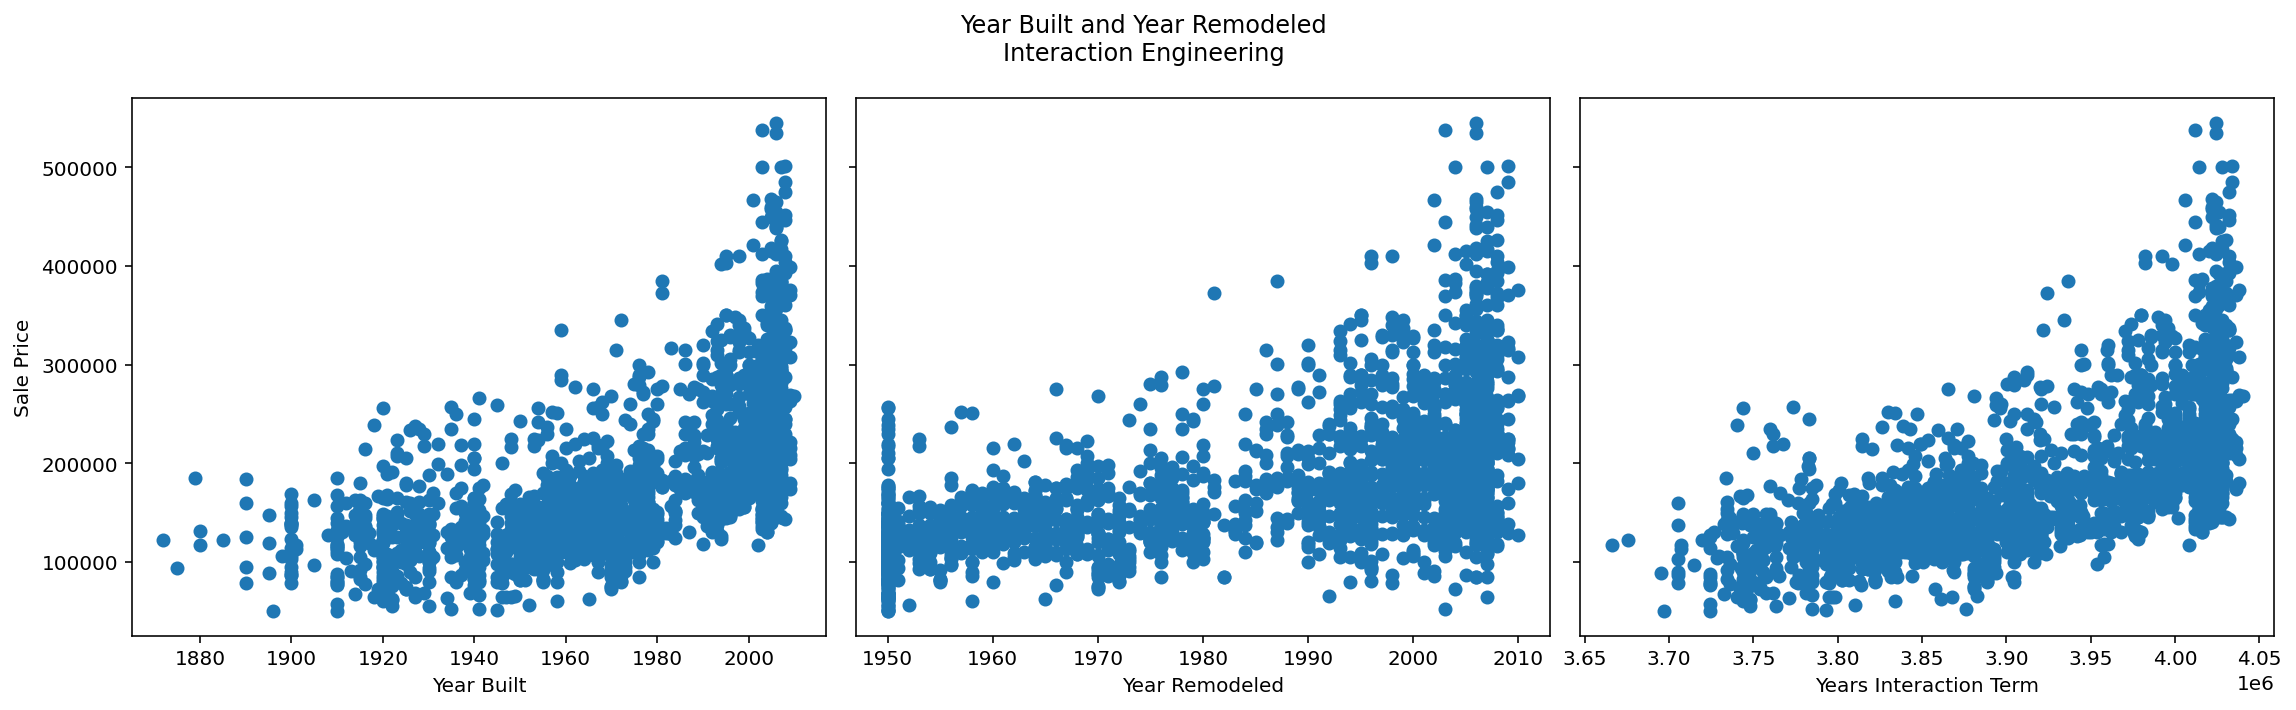

In [142]:
#years interaction term
train['years_interact'] = train['year_built'] * train['year_remod/add']

fig, ax = plt.subplots(1, 3, sharey='all', figsize=(16, 5))

for x, col in enumerate([x for x in train.columns if 'year' in x]):
    ax[x].scatter(train[col], train['saleprice'])
    ax[x].set_xlabel(col)
    
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Year Built')
ax[1].set_xlabel('Year Remodeled')
ax[2].set_xlabel('Years Interaction Term')
plt.suptitle('Year Built and Year Remodeled\nInteraction Engineering')
fig.tight_layout()
plt.show()


Another reason for the interaction term here is that you can see a slight curve in the scatter plot of sale price vs year built, indicating a relationship that is not perfectly linear. The interaction term shows a more linear relationship, making it a better predictor for sale price.

Year sold I am going to drop. Year sold reflects fluctuations in the market rather than intrinsic qualities of the home, was not indicated in my research as a powerful variable, does not have a high correlation with sale price, and has a bad VIF.

At this point I have also chosen not to look at number of beds or baths, as they are also not highly correlated with sale price, despite being indicated in my research.

#### Categorical Variables

My first categorical variables of interest are Neighborhood, Lot Configuration, and Fence. Neighborhood because it should be a good indicator for general prediction, and Lot Configuration, Fence, and Conditions 1 and 2 because they are related to the privacy of a peice of land.

I noticed that MS Subclass reads as a numerical category, but is actually nominal and must be converted. I am including it to have robust correlation comparison of my categorical variables.

In [115]:
train['ms_subclass'] = train['ms_subclass'].astype(str)

In [116]:
dummy_df = pd.get_dummies(train, columns=[x for x in train.columns if x not in train._get_numeric_data().columns]).drop(columns=[x for x in train._get_numeric_data().columns if x != 'saleprice'])
dummy_df.describe().T

,count,mean,std,min,25%,50%,75%,max
saleprice,2029.0,180710.177427,75419.657284,50000.0,130000.0,162500.0,213500.0,545224.0
ms_subclass_120,2029.0,0.065057,0.246687,0.0,0.0,0.0,0.0,1.0
ms_subclass_150,2029.0,0.000493,0.022200,0.0,0.0,0.0,0.0,1.0
ms_subclass_160,2029.0,0.043371,0.203741,0.0,0.0,0.0,0.0,1.0
ms_subclass_180,2029.0,0.005421,0.073448,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
sale_type_ConLI,2029.0,0.003450,0.058650,0.0,0.0,0.0,0.0,1.0
sale_type_ConLw,2029.0,0.002464,0.049592,0.0,0.0,0.0,0.0,1.0
sale_type_New,2029.0,0.075899,0.264902,0.0,0.0,0.0,0.0,1.0
sale_type_Oth,2029.0,0.001971,0.044368,0.0,0.0,0.0,0.0,1.0


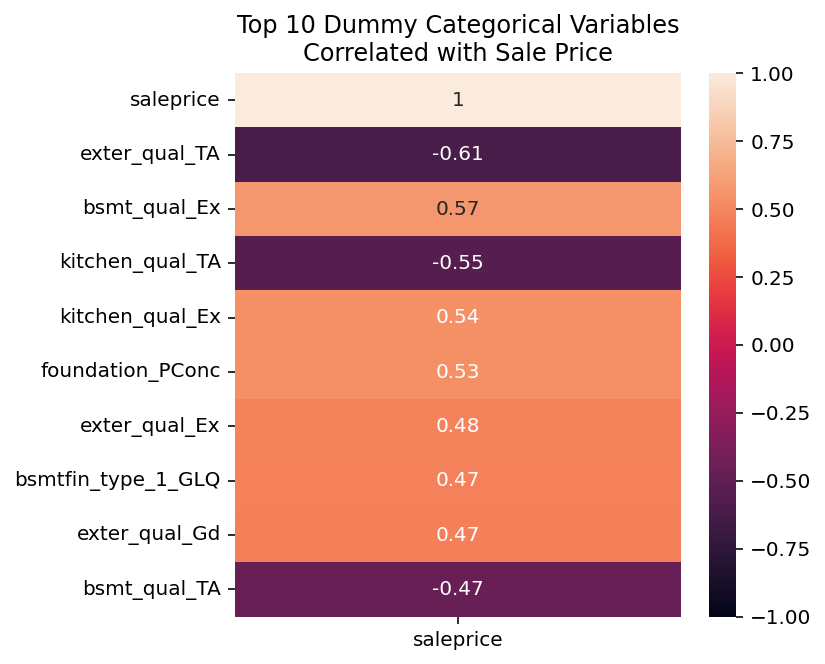

In [148]:
plt.figure(figsize=(5,5))
sns.heatmap(dummy_df.corr()[['saleprice']].sort_values(by='saleprice', key=abs, ascending=False).head(10), 
            annot=True, 
            vmin=-1, 
            vmax=1
)
plt.title('Top 10 Dummy Categorical Variables\nCorrelated with Sale Price')
plt.show()

Here I can immediately see that none of the variables I thought were important were the most correlated when it comes to predicting sale price. Because for this initial model my goal is just to get the most predictive one, I am going to pivot to cleaning the most indicated columns, and then circle back to see if my other columns I thought of enhance the prediction at all.

The top categorical columns shown above are all actually ordinal quality columns, so I will impute them as such. Because some houses don't have basements, basement quality is NaN, so I impute that as 0.

For now, I will assume that no categorical columns are correlated with each other or with the numerical columns.

In [118]:
dummy_vif = vif_df(dummy_df)
dummy_vif[dummy_vif['vif'] > 50000]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif
exterior_2nd_BrkFace,inf
exterior_1st_CemntBd,inf
exter_cond_Po,inf
exter_cond_TA,inf
foundation_BrkTil,inf
...,...
condition_1_RRNe,inf
condition_2_Feedr,inf
condition_1_RRNn,inf
condition_2_Norm,inf


In [120]:
#exter_qual
train['exter_qual_ord'] = train['exter_qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})

#bsmt_qual
train['bsmt_qual_ord'] = train['bsmt_qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})

#kitchen_qual
train['kitchen_qual_ord'] = train['kitchen_qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})


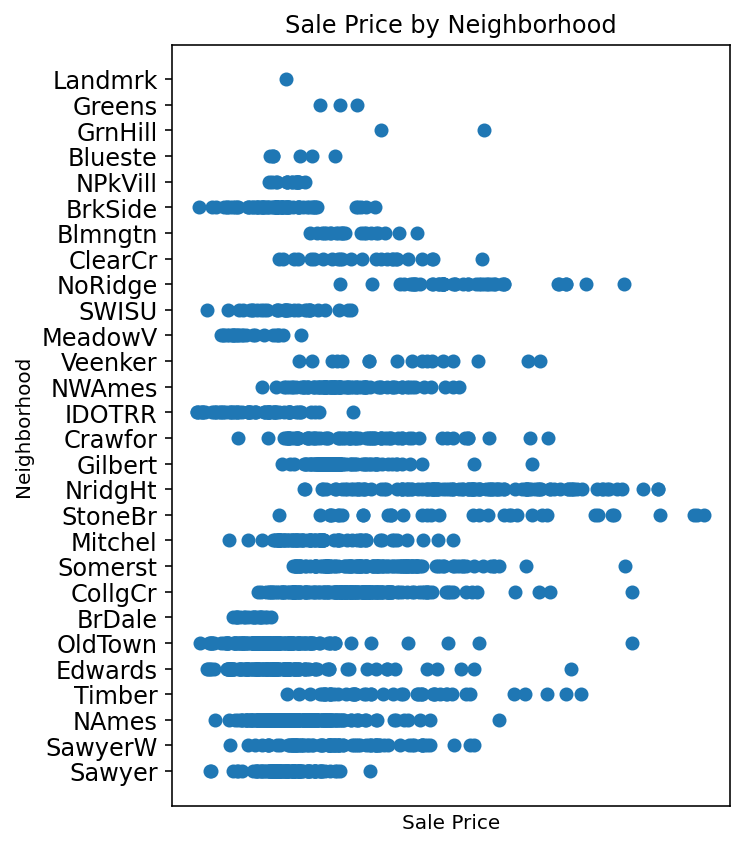

In [121]:
plt.figure(figsize=(5,7))
plt.scatter(train['saleprice'], train['neighborhood'])
plt.title('Sale Price by Neighborhood')
plt.xticks(ticks=[])
plt.xlabel('Sale Price')
plt.ylabel('Neighborhood')
plt.yticks(size=12)
plt.show()

Here we can see that the range of possible sale prices is definitely different by neighborhood, a good indicator that neighborhood will be a useful variable when predicting sale price.

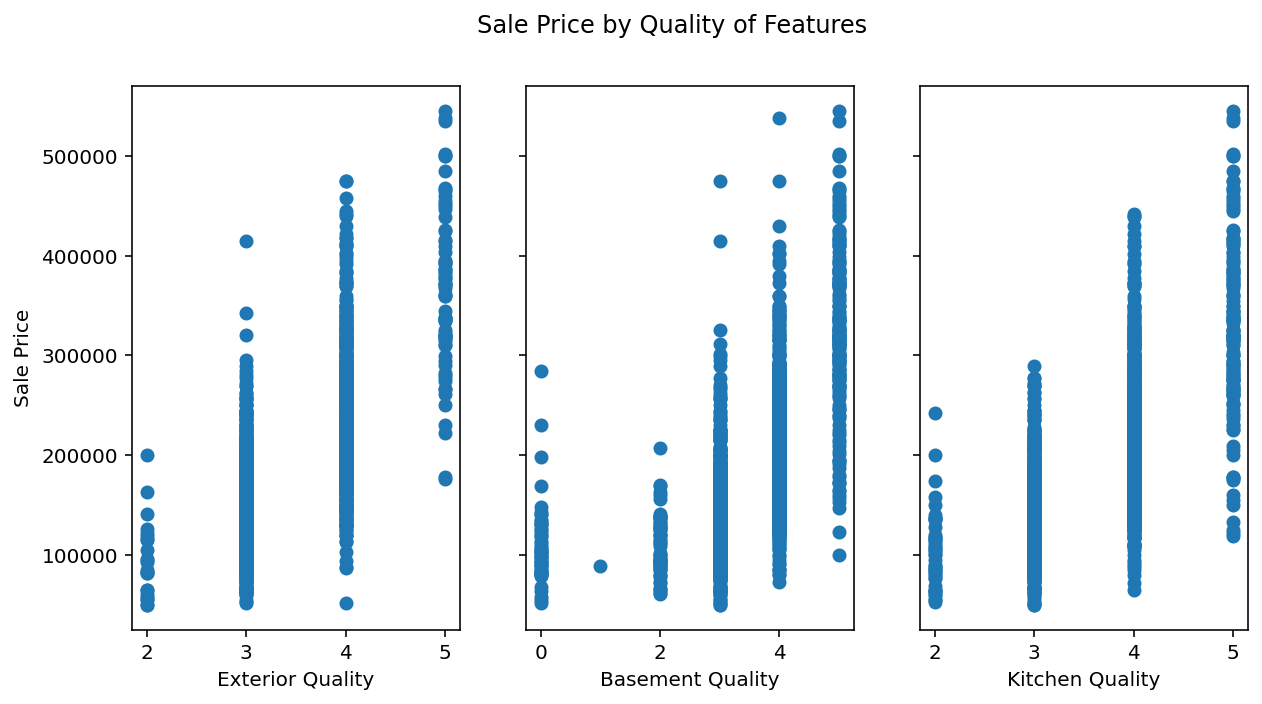

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(10,5), sharey=True)

for i, col in enumerate([x for x in train.columns if 'ord' in x]):
    ax[i].scatter(train[col], train['saleprice'])
    
plt.suptitle('Sale Price by Quality of Features')
ax[0].set_ylabel('Sale Price')
ax[0].set_xlabel('Exterior Quality')
ax[1].set_xlabel('Basement Quality')
ax[2].set_xlabel('Kitchen Quality')
plt.show()

The range of possible sale prices are also correlated with exterior, basement, and kitchen quality, making them also potentially useful variables.

## Iterative Modeling

The contents of this notebook you see above are actually the results of a couple of un-remarked-upon iterations of this work flow, condensed and made readable. These unseen iterations also included some modeling. The first model I used had no engineered columns, almost no deletion of outliers in the training set, and an RMSE of around 30,000. I spent a lot of time GridSearching on this first feature set before realizing that both my Ridge and Lasso models consistently preferred lower and lower regularization. With a little more reflection, I realized that this was because variance was so low that regularization was not yet needed. This indicated that a focus on features was more appropriate.

This was when I went back and showed my work above, ending with a feature set of `['overall_qual', 'total_overall_sf', 'garage_interact', 'years_interact', 'exter_qual_ord', 'bsmt_qual_ord', 'kitchen_qual_ord', 'lot_config', 'neighborhood']`. Here are the best results from my modeling on these features:

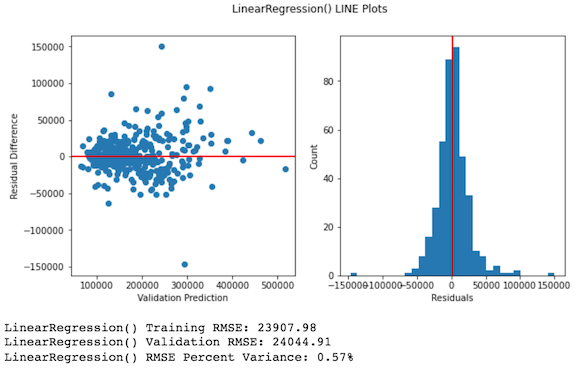

<sub>I learned to insert image from [this](https://www.geeksforgeeks.org/insert-image-in-a-jupyter-notebook/) Geeks for Geeks article</sub>

The first thing I noticed here is that there are some very distinct outliers. I want to find those first, and then move on to adding more features, since the variance is still very low and I have more target variables related to my problem statement to explore.

The major outliers I notice in my plots above that I have not yet addressed are in Year Built, below 1940.

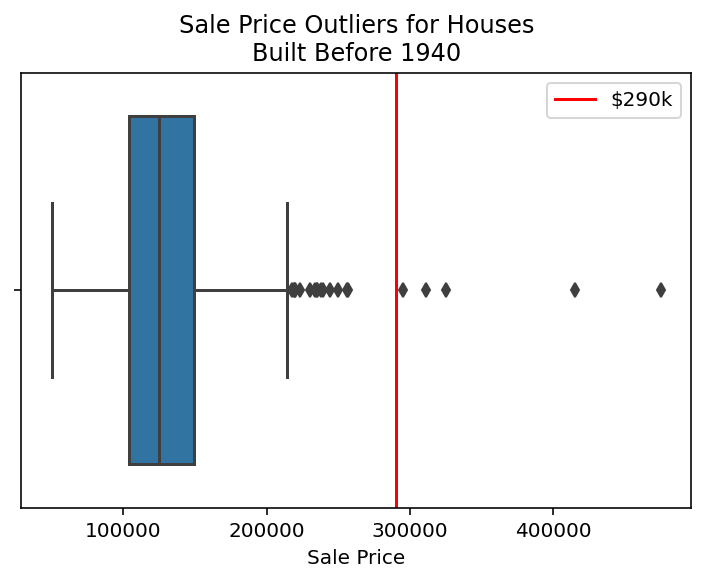

In [123]:
sns.boxplot(x=train[train['year_built'] <= 1940]['saleprice'])
plt.axvline(x=290000, color='red',label='$290k')
plt.title("Sale Price Outliers for Houses\nBuilt Before 1940")
plt.xlabel("Sale Price")
plt.legend()
plt.show()

One thing that I noticed from my original model to my newer models was that the new model does not take Beds or Baths into account, two traditional variables that are correlated with sale price.

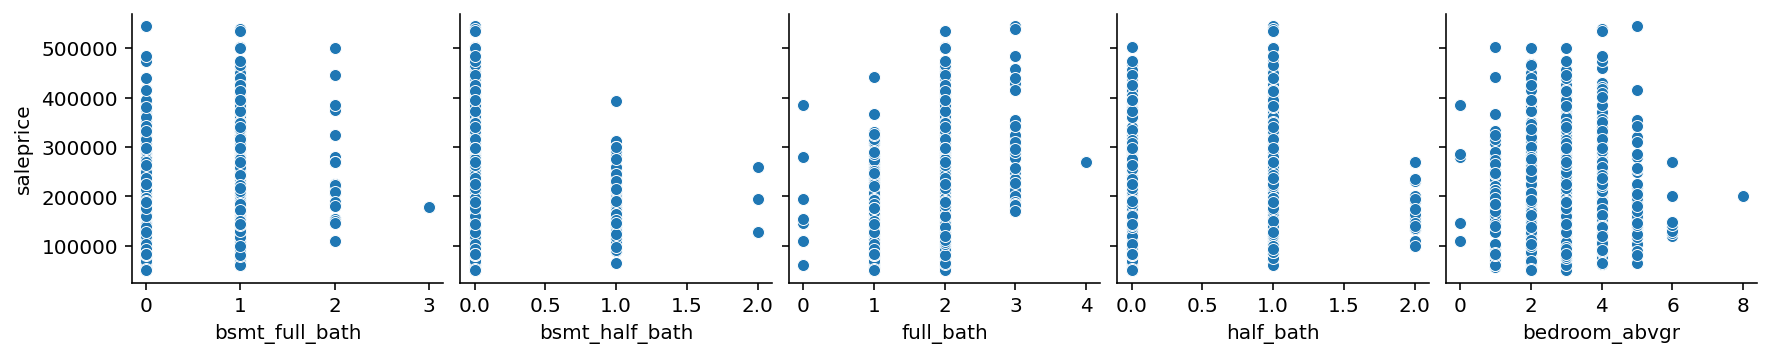

In [124]:
#unengineered bed and bath pair plots
sns.pairplot(train, x_vars=[x for x in train.columns if 'bedroom' in x or 'bath' in x], y_vars=['saleprice']);

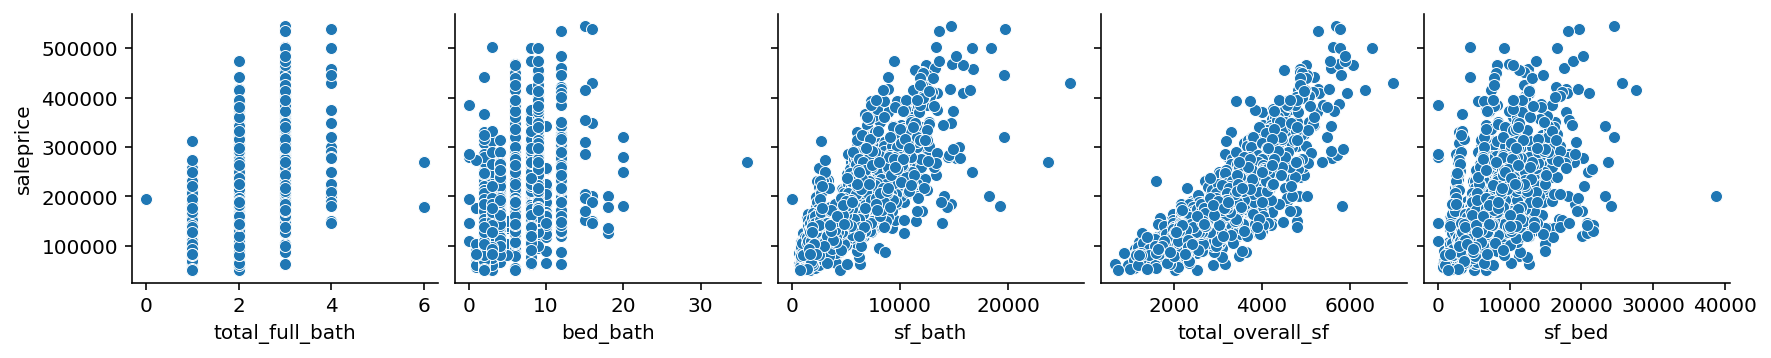

In [125]:
#a handful of engineered bed and bath options, with pairplots
train['total_full_bath'] = train['bsmt_full_bath'] + train['full_bath']
train['bed_bath'] = train['total_full_bath'] * train['bedroom_abvgr']
train['sf_bath'] = train['total_full_bath'] * (train['gr_liv_area'] + train['total_bsmt_sf'])
train['sf_bed'] = train['bedroom_abvgr'] * (train['gr_liv_area'] + train['total_bsmt_sf'])
sns.pairplot(train, x_vars=['total_full_bath', 'bed_bath', 'sf_bath', 'total_overall_sf', 'sf_bed'], y_vars=['saleprice']);

Here we can see that the interaction term of house square footage (excluding garage) and number of baths has a very clear linear trend with sale price, better in linearity than total overall squarefeet, but with a few more outliers on the lower end. Total full baths in the house also has a good linear trend with sale price, and shows some more outliers to be dropped.

Number of bedrooms above grade does not appear to be a very indicative variable, even as an interaction term with number of baths or squarefeet. This tracks with the correlation with sale price of just .12 that we can find in the original heatmap. Because of this lack of interaction, this variable is going to be dropped.

In [126]:
train = train.drop(columns=['bed_bath', 'sf_bed'])

Now that I've boosted signal for more of the standard features, I'm going to do another round of modeling with these new features before adding in my final privacy features.

#### Iterative Model: Engineered Features 2
Once again the base linear model performed the best of my three.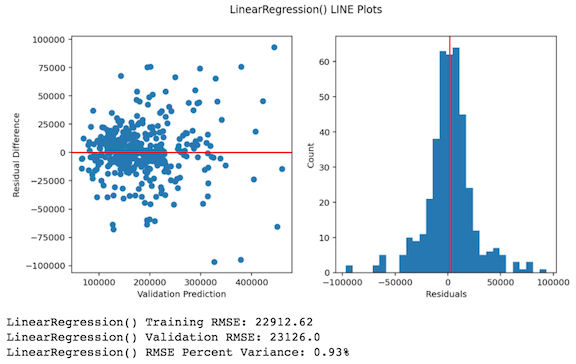

Here something strange started happening with my train/test split. In my null model I could see that the validation set actually performed better than the training set, which indicates a weird split of the data. I had this in my initial modeling as well, and fixed it by changing my random state. My hypothesis is that this change in the viability of my split is due to the new data cleaning that I did between running models, although I am not certain and have not been able to determine why the splits suddenly changed. I also realized at this point that I had failed to include drop first for my plain linear regression when I consolidated my pipelines, leading to multicollinearity that makes inference on those coefficients impossible. Changing random states halfway through an iterative project destroys repeatability, so I am keeping my random state of 8. I stored the previous iteration scores and started a new set of iterations with the updated pipeline to drop first for the non-regularized linear regression. I used my best multicollinear model as my final Kaggle submissions because my goal there is [prediction rather than interpretability](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.).

Although variance is still relatively low, and there are still many features to possibly be explored, I am going to stop myself from going down the "best predictive model" rabbit hole any further, and focus on my problem statement. The final features I would like to introduce are fencing and building type. Fencing is actually a relatively blank feature in this dataset, but is a specific concern for my clients, who value privacy on their land. In this dataset fence is an ordinal category, with the assumed value being 0-5, No Fence - Good Privacy Fence. For my clients, however, for whom a privacy fence is a high priority, a bad fence they have to tear down is actually worse than no fence at all. I am going to impute this variable to reflect that using an [ordinal technique](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/).

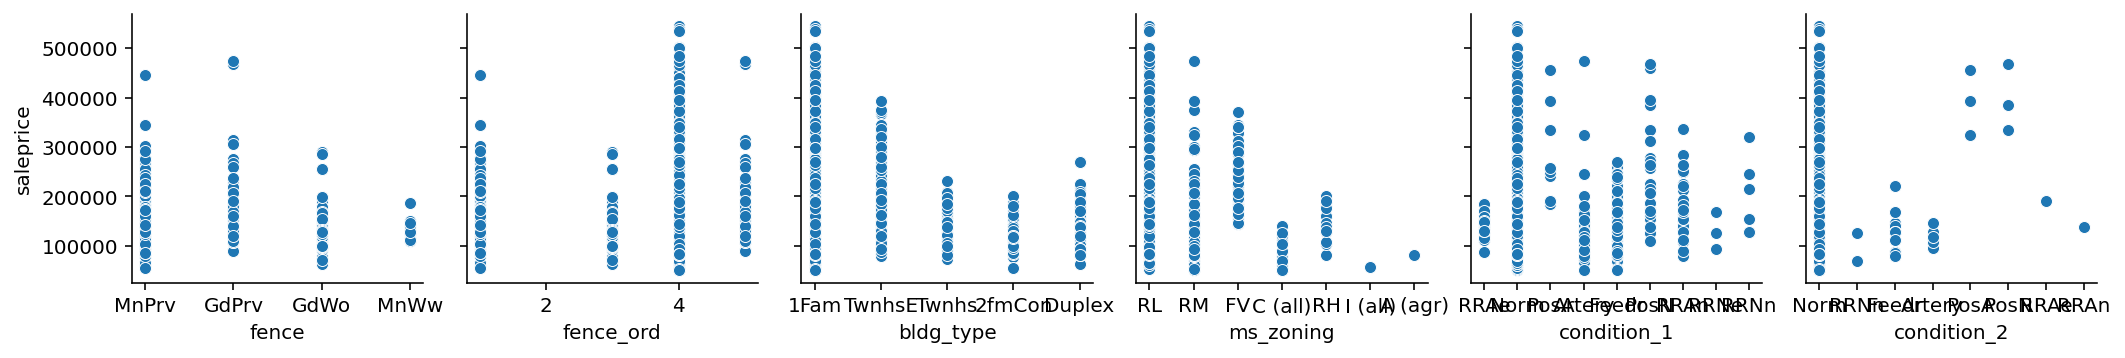

In [127]:
train['fence_ord'] = train['fence'].map({'GdPrv': 5, np.nan:4, 'GdWo': 3, 'MnPrv': 1, 'MnWw': 1})
sns.pairplot(train, x_vars=['fence', 'fence_ord', 'bldg_type', 'ms_zoning', 'condition_1', 'condition_2'], y_vars=['saleprice'])


Looking at the plot of fence_ord, there is such a spread in the No Fence, or 4, category that the variable may become unusable to the model. If it is predictive, however, then the houses that my fence model predicts as more expensive than with the regular model are better deals for my specific clients.

Building type is another variable to ordinalize in a similar way, except with this one, only single family homes are acceptable for my clients. Because of this I will also give single family home a stronger ordinal feature, leaving the others at 0.

In [128]:
train['bldg_type_ord'] = train['bldg_type'].map(lambda x: 5 if x == '1Fam' else 0)

#### Final Model
I ran scores for all of the models again on the fixed pipeline with all of the feature selection options I had previously made. The models performed slightly worse in general, but the final model, with the new privacy features, performed the best and seems to hit the sweet spot of bias and variance, with an R2 of .91 for both the training and the validation, and an RMSE slightly lower for the validation. Again, having a slightly lower RMSE for the validation set is probably an artifact of my newly strange train/test split, but overall the model performs well.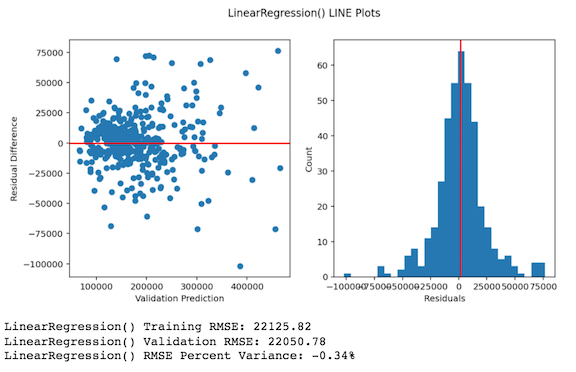

I ran a few GridSearches on this best model, to see if perhaps a better alpha would make a regularized model a better predictor, but none of the ranges of alphas I tried gave better results than the simple LinearRegression. Ultimately, I found regularization was not necessary. An argument can also be made that I could have just kept my multicollinear LinearRegression model as my production model, because I have not ended up needing to interpret the coefficients for my problem statement, but I feel it is best practice to have a model that can be interpreted over one that cannot.

Further interpretation for my target audience can be found in the interpretation notebook.

## Final Cleaning and Feature Engineering:

In [129]:
#drop training total squarefoot outliers, takes care of basement and gr_liv_area outliers as well
train = train.drop(train[train['total_overall_sf'] > 10000].index)

#drop frontage outliers
train = train.drop(train[train['lot_frontage'] > 200].index)

#drop lot area outliers
train = train.drop(train[train['lot_area'] > 100000].index)

#drop houses older than 1940 outlier saleprices
train = train.drop(train[(train['year_built'] <= 1940) & (train['saleprice'] > 290000)].index)

#drop 0 or 6 total full bath
train = train.drop(train[(train['total_full_bath'] < 1) | (train['total_full_bath'] > 4)].index)

#drop sf_bath outlier
train = train.drop(train[(train['sf_bath'] > 21000)].index)

#drop bed outlier
train = train.drop(train[train['bedroom_abvgr'] == 8].index)

In [130]:
def test_cleaner(df):
    """
    Returns a cleaned version of the given DataFrame, used to consolidate all the cleaning of the training set
    into one function on the test set.
    """
    #replace potential NaNs in appropriate numeric columns with 0
    for col in ['garage_area', 'garage_cars', 'mas_vnr_area', 'total_bsmt_sf', 'bsmt_unf_sf', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_full_bath', 'full_bath', 'bsmt_half_bath', 'half_bath']:
        df[col] = df[col].replace(np.nan, 0)
    
    #replace false garage type with NaN
    df.loc[df[df['garage_qual'].isna() & ~(df['garage_type'].isna())].index, 'garage_type'] = np.nan
    
    #make privacy fence column - GdPrv
    df['privacy_fence'] = df['fence'].map(lambda x: 1 if x == 'GdPrv' else 0)
    
    #make exter_qual ordinal
    df['exter_qual_ord'] = df['exter_qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})
    
    #bsmt_qual
    df['bsmt_qual_ord'] = df['bsmt_qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0})

    #kitchen_qual
    df['kitchen_qual_ord'] = df['kitchen_qual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
    
    ##feature engineering
    #more highly correlated than either year term individually
    df['years_interact'] = df['year_built'] * df['year_remod/add']
    
    #best square foot interaction I could find
    df['total_overall_sf'] = df['gr_liv_area'] + df['total_bsmt_sf'] + df['garage_area']
    
    #garage interaction term
    df['garage_interact'] = df['garage_area'] * df['garage_cars']
    
    #best bath interactions
    df['total_full_bath'] = df['bsmt_full_bath'] + df['full_bath']
    df['sf_bath'] = df['total_full_bath'] * (df['gr_liv_area'] + df['total_bsmt_sf'])
    
    #fence ordinal
    df['fence_ord'] = df['fence'].map({'GdPrv': 5, np.nan:4, 'GdWo': 3, 'MnPrv': 1, 'MnWw': 1})

    #building type ordinal
    df['bldg_type_ord'] = df['bldg_type'].map(lambda x: 5 if x == '1Fam' else 0)
    
    #attempted interaction terms that were nixed for better ones
    #df['sf_bath'] = df['total_full_bath'] * (df['gr_liv_area'] + df['total_bsmt_sf'])
    #df['fin_sf'] = df['gr_liv_area'] + df['total_bsmt_sf'] - df['bsmt_unf_sf']
    
    return df

In [131]:
#clean test data
test = test_cleaner(test)

#save cleaned data to new csvs
train.to_csv('../data/cleaned_train.csv', index=False)
test.to_csv('../data/cleaned_test.csv', index=False)